APRENDIZAJE DEL DETECTOR DE INTRUSIONES

El software para detectar intrusiones en la red protege una red informática de usuarios no autorizados, incluidos, quizás, personas con información privilegiada. La tarea de aprendizaje del detector de intrusiones es construir un modelo predictivo (es decir, un clasificador) capaz de distinguir entre conexiones "malas", llamadas intrusiones o ataques, y conexiones normales "buenas".

El Programa de evaluación de detección de intrusiones de DARPA de 1998 fue preparado y administrado por MIT Lincoln Labs. El objetivo era relevar y evaluar la investigación en detección de intrusos. Se proporcionó un conjunto estándar de datos para auditar, que incluye una amplia variedad de intrusiones simuladas en un entorno de red militar. El concurso de detección de intrusos KDD de 1999 utiliza una versión de este conjunto de datos.

Lincoln Labs estableció un entorno para adquirir nueve semanas de datos de volcado de TCP sin procesar para una red de área local (LAN) que simula una LAN típica de la Fuerza Aérea de EE. UU. Operaron la LAN como si fuera un verdadero entorno de la Fuerza Aérea, pero la salpicaron con múltiples ataques.

Los datos de entrenamiento sin procesar eran aproximadamente cuatro gigabytes de datos de volcado TCP binarios comprimidos de siete semanas de tráfico de red. Esto se procesó en aproximadamente cinco millones de registros de conexión. Del mismo modo, las dos semanas de datos de prueba arrojaron alrededor de dos millones de registros de conexión.

Una conexión es una secuencia de paquetes TCP que comienzan y terminan en momentos bien definidos, entre los cuales los datos fluyen hacia y desde una dirección IP de origen a una dirección IP de destino bajo algún protocolo bien definido. Cada conexión se etiqueta como normal o como un ataque, con exactamente un tipo de ataque específico. Cada registro de conexión consta de unos 100 bytes.

Los ataques se dividen en cuatro categorías principales:

    DOS: denegación de servicio, por ejemplo, syn flood;
    R2L: acceso no autorizado desde una máquina remota, por ejemplo, adivinar una contraseña;
    U2R: acceso no autorizado a privilegios de superusuario local (root), por ejemplo, varios ataques de "desbordamiento de búfer";
    Sondeo: vigilancia y otros sondeos, por ejemplo, escaneo de puertos.
    
Fuente: https://kdd.ics.uci.edu/databases/kddcup99/task.html

In [1]:
import numpy as np # importacion de librerias needed
import pandas as pd
import math as math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_kddcup99 #importa la herramientoa fetch_kuddcup99

In [3]:
X, y = fetch_kddcup99(percent10=True, download_if_missing=True, return_X_y=True) 
# Obtiene el conjunto de datos KDD Cup 99 con una muestra del 10%, descargando si es necesario, y devuelve las características X y las etiquetas y.
# percent10=True: este parámetro indica que se debe descargar y devolver una muestra del 10% del conjunto de datos completo.
# download_if_missing=True: este parámetro indica que se debe descargar el conjunto de datos si no se encuentra en el sistema.
# return_X_y=True: este parámetro indica que se deben devolver las características y las etiquetas del conjunto de datos como dos matrices separadas, que se asignan a las variables 
# X e y, respectivamente.

In [4]:
X # reviso la carga en variables Explicativas X

array([[0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
       [0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
       [0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
       ...,
       [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0],
       [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0],
       [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0]], dtype=object)

In [5]:
X.shape # revisamos el tamaño de la carga de registros en X

(494021, 41)

In [6]:
print(y) # reviso la carga en variable Objetivo y.

[b'normal.' b'normal.' b'normal.' ... b'normal.' b'normal.' b'normal.']


In [7]:
y.shape # revisamos el tamaño de la carga de registros en y. Como es la variable Objetivo, debe ser una tira de valores, es decir una columna; muchas filas!

(494021,)

In [8]:
# crea ahora el dataset con nombres en las columnas:
dt = [('duration', int),
      ('protocol_type', 'S4'),
      ('service', 'S11'),
      ('flag', 'S6'),
      ('src_bytes', int),
      ('dst_bytes', int),
      ('land', int),
      ('wrong_fragment', int),
      ('urgent', int),
      ('hot', int),
      ('num_failed_logins', int),
      ('logged_in', int),
      ('num_compromised', int),
      ('root_shell', int),
      ('su_attempted', int),
      ('num_root', int),
      ('num_file_creations', int),
      ('num_shells', int),
      ('num_access_files', int),
      ('num_outbound_cmds', int),
      ('is_host_login', int),
      ('is_guest_login', int),
      ('count', int),
      ('srv_count', int),
      ('serror_rate', float),
      ('srv_serror_rate', float),
      ('rerror_rate', float),
      ('srv_rerror_rate', float),
      ('same_srv_rate', float),
      ('diff_srv_rate', float),
      ('srv_diff_host_rate', float),
      ('dst_host_count', int),
      ('dst_host_srv_count', int),
      ('dst_host_same_srv_rate', float),
      ('dst_host_diff_srv_rate', float),
      ('dst_host_same_src_port_rate', float),
      ('dst_host_srv_diff_host_rate', float),
      ('dst_host_serror_rate', float),
      ('dst_host_srv_serror_rate', float),
      ('dst_host_rerror_rate', float),
      ('dst_host_srv_rerror_rate', float),
      ('labels', 'S16')]

In [9]:
column_names = [c[0] for c in dt] # por cada columna nombres en el dt
df_conexiones = pd.DataFrame(data=np.column_stack((X,y)),columns=column_names) # pueble la tabla basicamente.

In [10]:
 # un print del df_conexiones ya poblado

In [11]:
# df_conexiones = df_conexiones.astype(dt)
df_conexiones = df_conexiones.infer_objects()

In [12]:
df_conexiones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

In [13]:
df_conexiones.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,b'normal.'
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,b'normal.'
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,b'normal.'
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,b'normal.'
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,b'normal.'


In [14]:
df_conexiones.tail()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
494016,0,b'tcp',b'http',b'SF',310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,b'normal.'
494017,0,b'tcp',b'http',b'SF',282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,b'normal.'
494018,0,b'tcp',b'http',b'SF',203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,b'normal.'
494019,0,b'tcp',b'http',b'SF',291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,b'normal.'
494020,0,b'tcp',b'http',b'SF',219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,b'normal.'


In [15]:
df_conexiones.labels.unique() #datos unicos de columna labels! Este va a ser mi lista de valores Objetivo y. 

array([b'normal.', b'buffer_overflow.', b'loadmodule.', b'perl.',
       b'neptune.', b'smurf.', b'guess_passwd.', b'pod.', b'teardrop.',
       b'portsweep.', b'ipsweep.', b'land.', b'ftp_write.', b'back.',
       b'imap.', b'satan.', b'phf.', b'nmap.', b'multihop.',
       b'warezmaster.', b'warezclient.', b'spy.', b'rootkit.'],
      dtype=object)

# **Ejercicio 1**

CONSIGNA:

## 1. Mediante la función SelectKBest de ScikitLearn, detectar los features más relevantes del dataset provisto

In [16]:
# cargar datos y seleccionar variables más relevantes
# Separamos los features y los valores objetivo ; X (todas las columnas menos labels; col objetivo y)
X = df_conexiones.drop(columns=['labels']) # X (todas las columnas menos labels; col objetivo y)
y = df_conexiones['labels'] # Designo y, Variables Objetivo

In [17]:
X

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,...,9,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,b'tcp',b'http',b'SF',310,1881,0,0,0,0,...,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0
494017,0,b'tcp',b'http',b'SF',282,2286,0,0,0,0,...,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0
494018,0,b'tcp',b'http',b'SF',203,1200,0,0,0,0,...,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0
494019,0,b'tcp',b'http',b'SF',291,1200,0,0,0,0,...,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0


In [18]:
y

0         b'normal.'
1         b'normal.'
2         b'normal.'
3         b'normal.'
4         b'normal.'
             ...    
494016    b'normal.'
494017    b'normal.'
494018    b'normal.'
494019    b'normal.'
494020    b'normal.'
Name: labels, Length: 494021, dtype: object

### Para convertir el dataframe X en una tira binaria, podemos utilizar la función pandas get_dummies(). Esta función transforma todas las variables categóricas en variables binarias, generando una nueva columna binaria para cada categoría posible en la variable original.

In [19]:
import pandas as pd
X = pd.get_dummies(X,)
X


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_b'REJ',flag_b'RSTO',flag_b'RSTOS0',flag_b'RSTR',flag_b'S0',flag_b'S1',flag_b'S2',flag_b'S3',flag_b'SF',flag_b'SH'
0,0,181,5450,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,239,486,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,235,1337,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,219,1337,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,217,2032,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,310,1881,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
494017,0,282,2286,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
494018,0,203,1200,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
494019,0,291,1200,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# assume X contains both categorical and numerical variables
X = pd.get_dummies(X)  # perform one-hot encoding on categorical variables
selector = SelectKBest(chi2, k=10)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

selector = SelectKBest(chi2, k=10)
X_new = selector.fit_transform(X, y)


In [21]:
selector

SelectKBest(score_func=<function chi2 at 0x000001F39DF65240>)

In [22]:
# get boolean array indicating which features are selected
selected = selector.get_support()

# get list of column names in X
cols = X.columns.tolist()

# filter column names to get names of selected features
selected_cols = [cols[i] for i in range(len(cols)) if selected[i]]

# print names of selected features
print(selected_cols)


['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count', "service_b'private'"]


## **Ejercicio 2**

CONSIGNA:

1. Usando las variables más relevantes y separando los datos en "train" y "test", utilizar un árbol de decisión para realizar la predicción sobre si es una conexión normal o no:

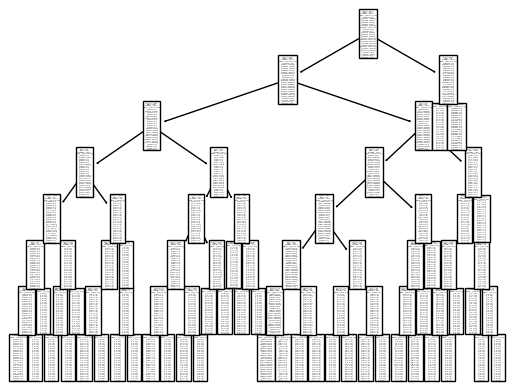

Accuracy: 0.9953038655394145



C:\Users\Luca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision per class: [1.         0.625      0.99253899 0.99535604 1.         1.
 0.99896816 0.9999644  0.         0.         0.99715909 1.
 0.98950932 0.99559247 0.99592236 0.98087647 0.99903115 0.99867475
 0.99964849 0.99915218 0.999914   0.625      0.95391705 0.
 0.        ]



C:\Users\Luca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: [1.         0.20833333 0.99883991 0.96257485 0.65035678 0.94722955
 0.9859522  0.99870826 0.         0.         0.48953975 0.96813354
 0.99949218 0.9998504  0.99974216 0.99979939 0.99484443 0.99994762
 0.99688022 0.98657578 0.99885738 0.45454545 0.575      0.
 0.        ]

F1 Score: [1.         0.3125     0.99567948 0.97869102 0.78814083 0.97289973
 0.9924175  0.99933593 0.         0.         0.65668849 0.98380879
 0.9944757  0.99771689 0.9978286  0.99024754 0.9969334  0.99931078
 0.99826244 0.99282415 0.99938541 0.52631579 0.71750433 0.
 0.        ]


C:\Users\Luca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn import tree


# dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# entrenar modelo de árbol de decisión con las variables seleccionadas
clf = DecisionTreeClassifier(max_depth=7)
clf.fit(X_train, y_train)

# hacer predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

tree.plot_tree(clf.fit(X_train,y_train))
plt.show()


# evaluar rendimiento del modelo en el conjunto de prueba
print('Accuracy:', accuracy_score(y_test, y_pred))
print()
print('Precision per class:', (precision_score(y_test, y_pred, average=None)))
print()
print('Recall:', recall_score(y_test, y_pred, average=None))
print()
print('F1 Score:', f1_score(y_test, y_pred, average=None))

C:\Users\Luca\AppData\Local\Temp\ipykernel_30080\3969672215.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_conexiones.corr()


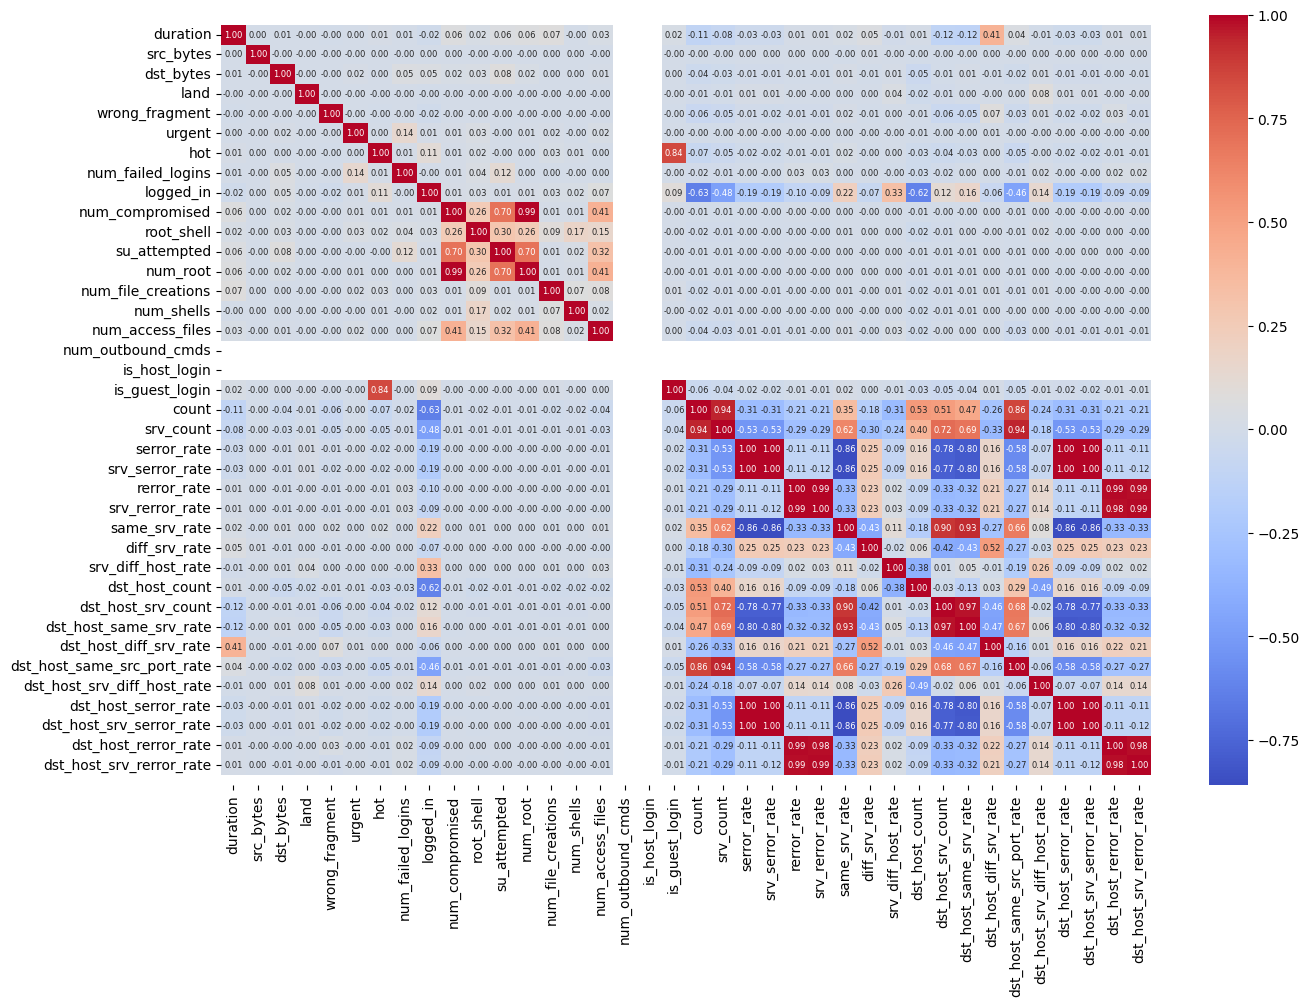

In [24]:
def plot_corre_heatmap(corr):
    '''
    Definimos una función para ayudarnos a graficar un heatmap de correlación
    '''
    plt.figure(figsize=(15,10))
    sns.heatmap(corr, cbar = True,  square = False, annot=True, fmt= '.2f'
                ,annot_kws={'size': 6},cmap= 'coolwarm')
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
    # Arreglamos un pequeño problema de visualización
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

corr = df_conexiones.corr()
plot_corre_heatmap(corr)

# Una diagonal con valores de 1.00 en cada una de sus celdas en una matriz de correlación significa que una variable está perfectamente correlacionada consigo misma. 
# En otras palabras, cada variable tiene una correlación perfecta de 1.00 consigo misma, lo que es lógico ya que cada variable tiene una relación perfecta con ella misma. 
# Este valor de 1.00 es el valor máximo que se puede obtener en la matriz de correlación y muestra una correlación perfecta positiva entre las variables.

In [25]:
X = X # Define las variables x a insertar en el modelo
y = y # Define variable objetivo para el modelo.

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from IPython.display import clear_output

tree_train_scores_mean = [] # Creando una lista vacía para almacenar las puntuaciones medias de entrenamiento del árbol de decisión
tree_train_scores_std = [] # Creando una lista vacía para almacenar las desviaciones estándar de las puntuaciones de entrenamiento del árbol de decisión
tree_test_scores_mean = [] # Creando una lista vacía para almacenar las puntuaciones medias de prueba del árbol de decisión
tree_test_scores_std = [] # Creando una lista vacía para almacenar las desviaciones estándar de las puntuaciones de prueba del árbol de decisión

profundidades = np.arange(1,25,1) # Creando un arreglo numpy que contiene profundidades del árbol de decisión desde 1 hasta 19
i = 0 # Inicializando el contador de iteraciones en 0
i_max = len(profundidades) # Asignando el número total de iteraciones a la variable i_max
for profundidad in profundidades: # Comenzando un bucle for para cada profundidad del árbol de decisión
    i = i + 1 # Incrementando el contador de iteraciones en 1
    clf = DecisionTreeClassifier(max_depth=profundidad) # Creando un clasificador de árbol de decisión con la profundidad dada
    tree_scores = cross_validate(clf, X, y, cv=5, return_train_score=True, n_jobs = -1) # Realizando la validación cruzada con el clasificador creado

    # Almacenando las puntuaciones medias y desviaciones estándar de entrenamiento y prueba del árbol de decisión en las listas correspondientes
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())
    
    clear_output(wait=True) # Limpiando la salida en pantalla
    print('Completado: ' + str(round(i / i_max * 100, 2)) + '%') # Mostrando el progreso del bucle en la pantalla


Completado: 100.0%


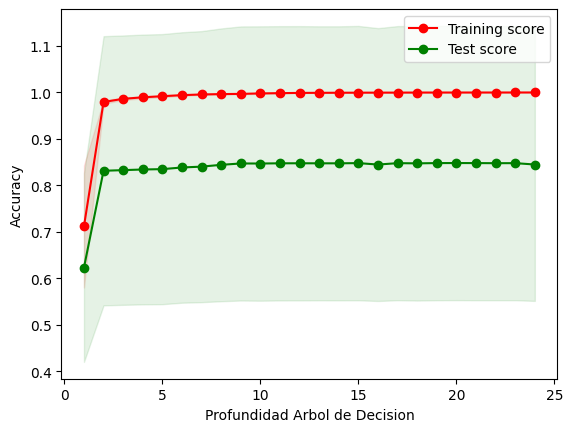

In [26]:
tree_train_scores_mean = np.array(tree_train_scores_mean) # Convirtiendo la lista de puntuaciones medias de entrenamiento en un arreglo numpy
tree_train_scores_std = np.array(tree_train_scores_std) # Convirtiendo la lista de desviaciones estándar de entrenamiento en un arreglo numpy
tree_test_scores_mean = np.array(tree_test_scores_mean) # Convirtiendo la lista de puntuaciones medias de prueba en un arreglo numpy
tree_test_scores_std = np.array(tree_test_scores_std) # Convirtiendo la lista de desviaciones estándar de prueba en un arreglo numpy

plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                                tree_train_scores_mean + tree_train_scores_std, alpha=0.1, color="r")  # Rellena la zona entre la puntuación media de entrenamiento más/menos la desviación estándar correspondiente para cada profundidad. El color es rojo con una transparencia de 0.1.

plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                                tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")  # Rellena la zona entre la puntuación media de prueba más/menos la desviación estándar correspondiente para cada profundidad. El color es verde con una transparencia de 0.1.

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")  # Dibuja una línea que muestra la puntuación media de entrenamiento para cada profundidad. Los puntos se marcan con un círculo y el color de la línea es rojo. Se agrega una etiqueta "Training score" a la leyenda del gráfico.

plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")  # Dibuja otra línea que muestra la puntuación media de prueba para cada profundidad. Los puntos se marcan con un círculo y el color de la línea es verde. Se agrega una etiqueta "Test score" a la leyenda del gráfico.

plt.legend()  # Agrega una leyenda al gráfico que muestra el color y el nombre de las líneas.
plt.ylabel('Accuracy')  # Etiqueta el eje Y con "Accuracy".
plt.xlabel('Profundidad Arbol de Decision')  # Etiqueta el eje X con "Profundidad Arbol de Decision".
plt.show()  # Muestra el gráfico completo con las zonas rellenas y las líneas trazadas.



CONSIGNA:

1. Usando las variables más relevantes y separando los datos en "train" y "test", utilizar un árbol de decisión para realizar la predicción sobre que tipo de conexión es pero teniendo en cuenta todas las posibles:

In [27]:
# ya atacada en la anterior, inclui todo-

**Ejercicio 3**

CONSIGNA:

1. Con el modelo del ejercicio 3, realizar esta vez una validación cruzada.
2. Mostrar la curva de validación

3. Aplicar GridSearch

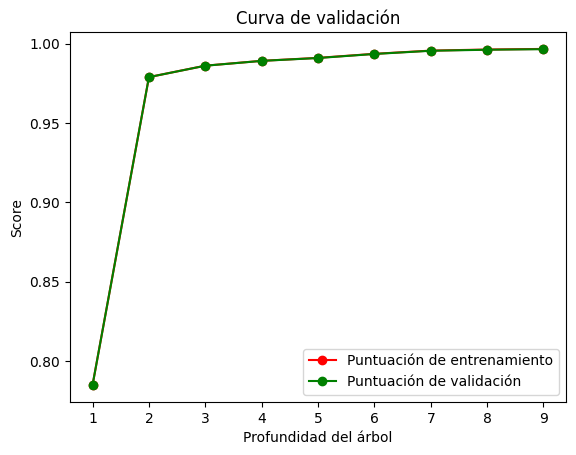

In [28]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

# Definir los valores para la búsqueda de los mejores hiperparámetros
param_grid = {'max_depth': range(1, 11)}

# Realizar búsqueda en grilla de los mejores hiperparámetros
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_

# Crear el modelo con los mejores hiperparámetros encontrados
clf = DecisionTreeClassifier(max_depth=best_params['max_depth'])

# Realizar validación cruzada con el modelo Gridsearch
cv_results = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True)

# Obtener las puntuaciones de entrenamiento y prueba
train_scores = cv_results['train_score']
test_scores = cv_results['test_score']

# Calcular las puntuaciones medias y desviaciones estándar de entrenamiento y prueba
train_scores_mean = np.mean(train_scores)
train_scores_std = np.std(train_scores)
test_scores_mean = np.mean(test_scores)
test_scores_std = np.std(test_scores)

# Graficar la curva de validación
plt.title("Curva de validación")
plt.xlabel("Profundidad del árbol")
plt.ylabel("Score")

param_range = range(1, 10)
train_scores, test_scores = validation_curve(estimator=clf, X=X_train, y=y_train, param_name="max_depth", param_range=param_range, cv=5)
plt.plot(param_range, np.mean(train_scores, axis=1), 'o-', color="r", label="Puntuación de entrenamiento")
plt.plot(param_range, np.mean(test_scores, axis=1), 'o-', color="g", label="Puntuación de validación")
plt.legend(loc="best")
plt.show()




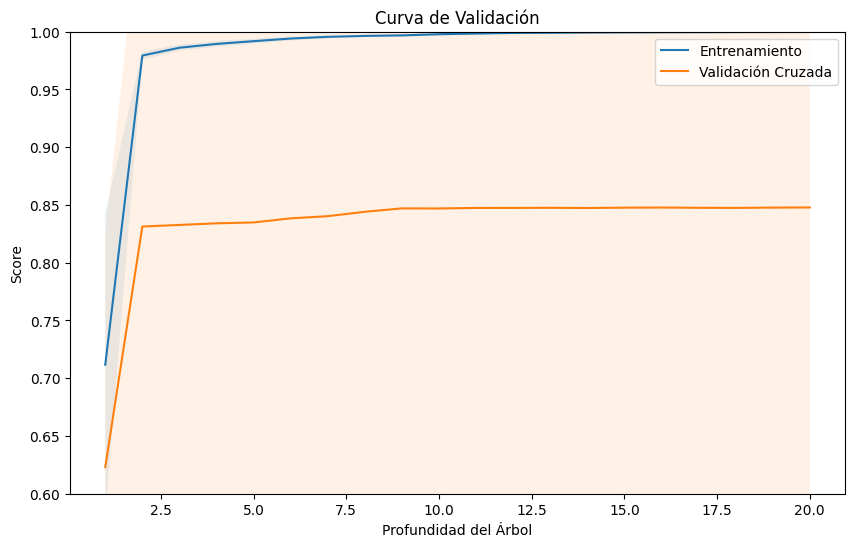

In [29]:
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Definir el modelo y los rangos de los parámetros a evaluar
model = DecisionTreeClassifier(random_state=42)
param_range = np.arange(1, 11)
train_scores, test_scores = validation_curve(model, X, y, param_name="max_depth", param_range=param_range, cv=5)

# Calcular los scores medios y sus intervalos de confianza
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Mostrar la curva de validación
plt.figure(figsize=(10, 6))
plt.title('Curva de Validación')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('Score')
plt.ylim(0.6, 1.0)
plt.plot(param_range, train_mean, label='Entrenamiento')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(param_range, test_mean, label='Validación Cruzada')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.legend()
plt.show()


In [30]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'criterion': ['gini', 'entropy']
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Accuracy:', grid_search.score(X_test, y_test))


Best parameters: {'criterion': 'entropy', 'max_depth': 9}
Accuracy: 0.9987180092708172
